In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from umap import UMAP
import os
import sys

from scipy.ndimage import uniform_filter1d
import scipy.io
import requests

C:\Users\Facundo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#STIMULI
# dirf = r'C:\Users\Facundo\Desktop\CONICET\Doctorado\Cursos\Neuro Match Academy\Project Continuation/'
# MOUSE_IND = 0

# mice_files = ['stimspont_M170604_MP031_20170627.mat',"stimspont_M150824_MP019_2016-03-23.mat","stimspont_M170714_MP032_2017-08-01.mat","stimspont_M170714_MP032_2017-08-01.mat"]
# mice_names = ['mouse1','mouse2','mouse3','mouse4']

# dat = scipy.io.loadmat(dirf+mice_files[MOUSE_IND])

In [18]:
#NON STIMULI
dirf = r'C:\Users\Facundo\Desktop\CONICET\Doctorado\Cursos\Neuro Match Academy\Project Continuation/'
general_url = 'https://figshare.com/articles/dataset/Recordings_of_ten_thousand_neurons_in_visual_cortex_during_spontaneous_behaviors/6163622/'
MOUSE_IND = 0

mice_files = ['spont_M161025_MP030_20161120.mat','spont_M170717_MP033_20170818.mat','spont_M170717_MP034_20170825.mat',
 'spont_M160825_MP027_20161212.mat','spont_M160907_MP028_20160926.mat','spont_M161025_MP030_20170616.mat',
 'spont_M161025_MP030_20170623.mat','spont_M170714_MP032_20170804.mat','spont_M150824_MP019_20160405.mat']

mice_names =['mouse1','mouse2','mouse3','mouse4','mouse5','mouse6','mouse7','mouse8','mouse9']

rat = mice_files[MOUSE_IND]
fname = mice_files[MOUSE_IND]#"spont_M170717_MP034_2017-08-25.mat"
url = general_url#"https://figshare.com/ndownloader/files/11492261"

# dat = scipy.io.loadmat(dirf+mice_files[MOUSE_IND])

In [4]:
# sresp = dat['stim'][0]['resp'][0] # stim x neurons
# # spont = dat['stim'][0]['spont'][0] # timepts x neurons
# istim = (dat['stim'][0]['istim'][0]).astype(np.int32) # stim ids 
# istim -= 1 # get out of MATLAB convention
# istim = istim[:,0]

# pupilArea = dat['beh'][0]['pupil'][0]['area'][0][0]
# pupilArea = np.array([[x for x in pupilArea.T[0] if not np.isnan(x)]]).T #original pupilArea contains nans
# runSpeed = dat['beh'][0]['runSpeed'][0]
# runSpeed = np.array([[x for x in runSpeed.T[0] if not np.isnan(x)]]).T #original runSpeed contains nans
# runAngle = dat['beh'][0]['runAngle'][0]
# motionSVD = dat['beh'][0]['face'][0]['motionSVD'][0][0]
# motionMask = dat['beh'][0]['face'][0]['motionMask'][0][0]
# xyz = dat['med']

# print('full resp: ', dat['Fsp'].shape)
# # print("sresp: ", sresp.shape)
# # print("istim: ", istim.shape)
# print("pupilarea: ", pupilArea.shape)
# print("runAngle: ", runAngle.shape)
# print("runSpeed: ", runSpeed.shape)
# print("motionSVD: ", motionSVD.shape)
# print("motionMask: ", motionMask.shape)

# print("xyz: ", xyz.shape)

# if dat['Fsp'].shape[1]!= len(pupilArea) or dat['Fsp'].shape[1]!= len(runSpeed):
#     print('WARNING! Vector does not match nueral matrix!')

## Import Packages

In [5]:
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
from sklearn.decomposition import PCA
import sklearn.model_selection as ms
import sklearn.linear_model as lm
import sklearn as sk
from sklearn import linear_model

import random
import seaborn as sns

In [6]:
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten
# from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ReLU
# from keras.layers.advanced_activations import Tanh
import tensorflow as tf
import keras

#### z-score

In [12]:
#ONLY STIM
# folderstim = 'data_only_stimuli'
# Z = zscore(dat['Fsp'].T[np.where(dat['stimtpt'].T[0]>0)[0]].T, axis=1)
# Z = np.nan_to_num(Z)
# pupilArea = pupilArea[np.where(dat['stimtpt'].T[0]>0)[0]]
# runSpeed  = runSpeed[np.where(dat['stimtpt'].T[0]>0)[0]]

In [13]:
# # @title take PCA after preparing data by z-score
# folderstim = 'data_simuli'
# Z = zscore(dat['Fsp'], axis=1)
# Z = np.nan_to_num(Z)

In [14]:
# pca_model = PCA(n_components=500)
# pca_zscore = pca_model.fit_transform(Z.T)

#### Custom functions

In [7]:
def create_custom_model(input_dim, output_dim, nodes, name='model',activation = ['relu'],activation_out='linear'):
    def create_model():
        # Create model
        model = Sequential(name=name)
        if len(nodes)==0:
            model.add(Dense(output_dim, input_dim=input_dim, activation=activation[0]))
        else:
            model.add(Dense(nodes[0], input_dim=input_dim, activation=activation[0]))
            for i in range(1,len(nodes)):
                model.add(Dense(nodes[i], input_dim=nodes[i-1], activation=activation[i]))
            model.add(Dense(output_dim, activation=activation_out))

        # Compile model
        model.compile(loss='mse',   optimizer='adam')#,   metrics=['mse'])
        return model
    return create_model

In [8]:
def split_dataset(Xdata,Ydata,trials,i,T):
    L = Xdata.shape[0]
    i_0 = i*round(L/trials)
    i_f = i_0 + L-T
    X_tr, X_tst = np.zeros((L-T,Xdata.shape[1])), np.zeros((T,Xdata.shape[1]))
    y_tr, y_tst = np.zeros((L-T,1)), np.zeros((T,1))

    if i_f>L:
        X_tr[0:i_f-L] = Xdata[0:i_f-L]
        X_tr[i_f-L:] = Xdata[i_0:]
        X_tst = Xdata[i_f-L:i_0]
        y_tr[0:i_f-L] = Ydata[0:i_f-L]
        y_tr[i_f-L:] = Ydata[i_0:]
        y_tst = Ydata[i_f-L:i_0]
    elif i_f+T == L:
        X_tr = Xdata[i_0:i_f]
        X_tst = Xdata[i_f:]
        y_tr = Ydata[i_0:i_f]
        y_tst = Ydata[i_f:]
    else:
        X_tr = Xdata[i_0:i_f]
        X_tst[:L-i_f] = Xdata[i_f:]
        X_tst[L-i_f:] = Xdata[:i_0]
        y_tr = Ydata[i_0:i_f]
        y_tst[:L-i_f] = Ydata[i_f:]
        y_tst[L-i_f:] = Ydata[:i_0]

    return X_tr, X_tst, y_tr, y_tst

In [9]:
def general_decoder(XData,yData,pars=[],trials = 15):
    trained_models = []
    MSE = []
    R2 = []
    predictions = []
    
    T = round(len(yData)*0.25)
    L = XData.shape[0]
    for i in range(trials):

        X_train, X_test, y_train, y_test = split_dataset(XData,yData,trials,i,T)
        
        if len(pars)>0:   
            model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf',activation = ['relu','tanh'])
            model = model_tf()
            model.fit(X_train,y_train,batch_size=pars[0],epochs=pars[1],verbose=pars[2],validation_data=(X_test, y_test),callbacks=[pars[3]])
        else:
            model = linear_model.LinearRegression()
            model.fit(X_train,y_train)
            
#         trained_models.append(model)

        y_pred = model.predict(X_test)
        predictions.append([y_pred,y_test,X_test])
        R2.append(sk.metrics.r2_score(y_test,y_pred))
        MSE.append(sk.metrics.mean_squared_error(y_test,y_pred,squared=False))
                
    return trained_models, MSE, R2, predictions

In [10]:
def general_depth_decoder(z_depth,XData,yData,pars=[],trials = 5, trials_neuron = 1,nonPCA = False):
    
    T = round(len(yData)*0.25)
    L = XData.shape[0]

    pca_layers_zscore = []
    z_values = np.unique(z_depth)

    minimal_neuron_count = min([len(np.where(z_depth == z_values[layer])[0]) for layer in range(len(z_values))]) #number of neurons in the layer which has the least number of neurons
    minimal_neuron_count = round(minimal_neuron_count*0.9) # grab 90% of this number
    
    trained_models = []
    MSE = np.zeros((len(z_values),trials_neuron,trials))
    R2 = np.zeros((len(z_values),trials_neuron,trials))
    predictions = []
    
    for layer in range(len(z_values)):

#         trained_models.append([])
        predictions.append([]) 

        for i in range(trials_neuron):

            pca_layer_model = PCA(n_components=500)

            index = np.where(z_depth == z_values[layer])[0]
            random.shuffle(index)
            pca_layers_zscore.append(pca_model.fit_transform(XData[index[:minimal_neuron_count]].T))

#             trained_models[-1].append([])
            predictions[-1].append([])

            for j in range(trials):

                X_train, X_test, y_train, y_test = split_dataset(pca_layers_zscore[-1],yData,trials,j,T)

                if len(pars)>0:   
                    model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf',activation = ['relu','tanh'])
                    model = model_tf()
                    model.fit(X_train,y_train,batch_size=pars[0],epochs=pars[1],verbose=pars[2],validation_data=(X_test, y_test),callbacks=[pars[3]])
                else:
                    model = linear_model.LinearRegression()
                    model.fit(X_train,y_train)

#                 trained_models[-1].append(model)

                y_pred = model.predict(X_test)
                predictions[-1].append([y_pred,y_test,X_test])
                R2[layer,i,j] = sk.metrics.r2_score(y_test,y_pred)
                MSE[layer,i,j] = sk.metrics.mean_squared_error(y_test,y_pred,squared=False)
                
                print(layer,i,j)
                
    return trained_models, MSE, R2, predictions

In [54]:
int(True)

1

In [55]:
def group_depth_decoder(z_depth,XData,yData,groups=[[125,255],[375,475]],pars=[],trials = 5, trials_neuron = 1,nonPCA = False):
    
    T = round(len(yData)*0.25)
    L = XData.shape[0]

    pca_layers_zscore = []
    z_values = np.unique(z_depth)
    
#     minimal_neuron_count = min([len(np.where(z_depth == z_values[layer])[0]) for layer in range(len(z_values))]) #number of neurons in the layer which has the least number of neurons
#     minimal_neuron_count = round(minimal_neuron_count*0.9) # grab 90% of this number
    
    trained_models = []
    MSE = np.zeros((len(z_values),trials_neuron,trials))
    R2 = np.zeros((len(z_values),trials_neuron,trials))
    predictions = []
    
    neurons_per_layer = []
    index_group = []
    for g in groups:
        print(g)
        index_group.append(np.array([int(x) for x in (z_depth>=g[0])*(z_depth<=g[1])]))
        print(index_group[-1])
        neurons_per_layer.append(len(index_group[-1]))
        
    minimal_neuron_count = round(min(neurons_per_layer)*0.9)
    
    for layer in range(len(groups)):
#         trained_models.append([])
        predictions.append([]) 

        for i in range(trials_neuron):

            pca_layer_model = PCA(n_components=500)
            
            index = index_group[layer]
            random.shuffle(index)
            pca_layers_zscore.append(pca_model.fit_transform(XData[index[:minimal_neuron_count]].T))

#             trained_models[-1].append([])
            predictions[-1].append([])

            for j in range(trials):

                X_train, X_test, y_train, y_test = split_dataset(pca_layers_zscore[-1],yData,trials,j,T)

                if len(pars)>0:   
                    model_tf = create_custom_model(X_train.shape[1], 1, [100,100], name='model_tf',activation = ['relu','tanh'])
                    model = model_tf()
                    model.fit(X_train,y_train,batch_size=pars[0],epochs=pars[1],verbose=pars[2],validation_data=(X_test, y_test),callbacks=[pars[3]])
                else:
                    model = linear_model.LinearRegression()
                    model.fit(X_train,y_train)

#                 trained_models[-1].append(model)

                y_pred = model.predict(X_test)
                predictions[-1].append([y_pred,y_test,X_test])
                R2[layer,i,j] = sk.metrics.r2_score(y_test,y_pred)
                MSE[layer,i,j] = sk.metrics.mean_squared_error(y_test,y_pred,squared=False)
                
                print(layer,i,j)
                
    return trained_models, MSE, R2, predictions

In [12]:
def plot_full_neurons(MSE_ffnn,MSE_linear,R2_ffnn,R2_linear):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(15,10))
    pass

    plt.subplot(2,1,1)
    ax = sns.boxplot(data=[MSE_ffnn,MSE_linear])
    ax = sns.stripplot(data=[MSE_ffnn,MSE_linear],color='orange')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['FFNN','Linear'])#, minor=False, rotation=45)
    plt.ylabel('MSE')

    plt.subplot(2,1,2)
    ax = sns.boxplot(data=[R2_ffnn,R2_linear])
    ax = sns.stripplot(data=[R2_ffnn,R2_linear],color='orange')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['FFNN','Linear'])#, minor=False, rotation=45)
    plt.ylabel('$R^2$')

In [13]:
def plot_depth(MSE_ffnnDEPTH,R2_ffnnDEPTH,MSE_linearDEPTH,R2_linearDEPTH):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(20,8))
    pass

    DATA_MSEffnn = []
    for i in range(len(MSE_ffnnDEPTH)):
        DATA_MSEffnn.append([x for K in MSE_ffnnDEPTH[i] for x in K])

    DATA_R2ffnn = []
    for i in range(len(R2_ffnnDEPTH)):
        DATA_R2ffnn.append([x for K in R2_ffnnDEPTH[i] for x in K])

    DATA_MSElinear = []
    for i in range(len(MSE_linearDEPTH)):
        DATA_MSElinear.append([x for K in MSE_linearDEPTH[i] for x in K])

    DATA_R2linear = []
    for i in range(len(R2_linearDEPTH)):
        DATA_R2linear.append([x for K in R2_linearDEPTH[i] for x in K])

    plt.subplot(2,2,1)
    ax = sns.boxplot(data=DATA_MSEffnn)
    ax = sns.stripplot(data=DATA_MSEffnn,color='orange')
    ax.set_xticks([x for x in range(len(R2_ffnnDEPTH))])
    ax.set_xticklabels(list(range(1,len(R2_ffnnDEPTH)+1)))
    plt.ylabel('MSE')
    plt.xlabel('Layers')
    plt.title('Feedforward neural network')
    # plt.ylim([140,400])

    plt.subplot(2,2,2)
    ax = sns.boxplot(data=DATA_MSElinear)
    ax = sns.stripplot(data=DATA_MSElinear,color='orange')
    ax.set_xticks([x for x in range(len(R2_ffnnDEPTH))])
    ax.set_xticklabels(list(range(1,len(R2_ffnnDEPTH)+1)))
    plt.ylabel('MSE')
    plt.xlabel('Layers')
    plt.title('Linear decoder')
    # plt.ylim([140,400])

    plt.subplot(2,2,3)
    ax = sns.boxplot(data=DATA_R2ffnn)
    ax = sns.stripplot(data=DATA_R2ffnn,color='orange')
    ax.set_xticks([x for x in range(len(R2_ffnnDEPTH))])
    ax.set_xticklabels(list(range(1,len(R2_ffnnDEPTH)+1)))
    plt.ylabel('$R^2$')
    plt.xlabel('Layers')
    plt.title('Feedforward neural network')
    # plt.ylim([0,1])

    plt.subplot(2,2,4)
    ax = sns.boxplot(data=DATA_R2linear)
    ax = sns.stripplot(data=DATA_R2linear,color='orange')
    ax.set_xticks([x for x in range(len(R2_ffnnDEPTH))])
    ax.set_xticklabels(list(range(1,len(R2_ffnnDEPTH)+1)))
    plt.ylabel('$R^2$')
    plt.xlabel('Layers')
    plt.title('Linear decoder')
    # plt.ylim([0,1])

    plt.tight_layout()

In [14]:
def save_list(data2save,name,dir2save=r'C:\Users\Facundo\Desktop\CONICET\Doctorado\Cursos\Neuro Match Academy\Project Continuation\Aim-Eye\data_only_stimuli'):
    # open file in write mode
    with open(dir2save+dir2save[2]+name+'.txt', 'w') as fp:
        for item in data2save:
            # write each item on a new line
            fp.write("%s\n" % item)
        print('Done')

In [15]:
n_epochs = 100
batch_size = 15
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4) #if there is no improvement in validation loss function for "#patience" epochs, then training stops
pars = [batch_size,n_epochs,0,[callback]]

### Automatization

In [35]:
for MOUSE_IND in [0,1,3,4,5,6,7,8]:
    mouse_decoding = {}
    
    rat = mice_files[MOUSE_IND]
    fname = mice_files[MOUSE_IND]#"spont_M170717_MP034_2017-08-25.mat"
    url = general_url#"https://figshare.com/ndownloader/files/11492261"

    dat = scipy.io.loadmat(dirf+mice_files[MOUSE_IND])
    
    pupilArea = dat['beh'][0]['pupil'][0]['area'][0][0]
    pupilArea = np.array([[x for x in pupilArea.T[0] if not np.isnan(x)]]).T #original pupilArea contains nans
    runSpeed = dat['beh'][0]['runSpeed'][0]
    runSpeed = np.array([[x for x in runSpeed.T[0] if not np.isnan(x)]]).T #original runSpeed contains nans
    
    pupilArea_norm = (pupilArea-min(pupilArea))/(max(pupilArea)-min(pupilArea))
    runSpeed_norm = (runSpeed-min(runSpeed))/(max(runSpeed)-min(runSpeed))
    
    Z = zscore(dat['Fsp'], axis=1)
    Z = np.nan_to_num(Z)
    pca_model = PCA(n_components=500)
    pca_zscore = pca_model.fit_transform(Z.T)

    trained_models_ffnn, MSE_ffnn, R2_ffnn, predictions_ffnn = general_decoder(pca_zscore,pupilArea_norm,pars,trials = 15)
    trained_models_linear, MSE_linear, R2_linear, predictions_linear = general_decoder(pca_zscore,pupilArea_norm,[],trials = 15)
    
    trained_models_ffnnDEPTH, MSE_ffnnDEPTH, R2_ffnnDEPTH, predictions_ffnnDEPTH = group_depth_decoder(dat['med'].T[-1],Z,pupilArea_norm,pars)
    trained_models_linearDEPTH, MSE_linearDEPTH, R2_linearDEPTH, predictions_linearDEPTH = group_depth_decoder(dat['med'].T[-1],Z,pupilArea_norm,[])

    SPEEDtrained_models_ffnn, SPEEDMSE_ffnn, SPEEDR2_ffnn, SPEEDpredictions_ffnn = general_decoder(pca_zscore,runSpeed_norm,pars=pars,trials = 15)
    SPEEDtrained_models_linear, SPEEDMSE_linear, SPEEDR2_linear, SPEEDpredictions_linear = general_decoder(pca_zscore,runSpeed_norm,[],trials = 15)

    SPEEDtrained_models_ffnnDEPTH, SPEEDMSE_ffnnDEPTH, SPEEDR2_ffnnDEPTH, SPEEDpredictions_ffnnDEPTH = group_depth_decoder(dat['med'].T[-1],Z,runSpeed_norm,pars)
    SPEEDtrained_models_linearDEPTH, SPEEDMSE_linearDEPTH, SPEEDR2_linearDEPTH, SPEEDpredictions_linearDEPTH = group_depth_decoder(dat['med'].T[-1],Z,runSpeed_norm,[])

    mouse_decoding['pupilArea'] = pupilArea.T[0]
    mouse_decoding['runSpeed'] = runSpeed.T[0]
    mouse_decoding['xyz'] = dat['med']
    mouse_decoding['size'] = np.array(x[0][0] for x in dat['stat']['footprint'].T[0])
    mouse_decoding['decoding'] = {
                        'all_neurons': {
                                'Linear': {
                                    'Pupil_Area': {
                                        'R2': R2_linear,
                                        'MSE': MSE_linear
                                        },
                                    'Speed': {
                                        'R2': SPEEDR2_linear,
                                        'MSE': SPEEDMSE_linear
                                        }
                                    },
                                'FFNN': {
                                    'Pupil_Area': {
                                        'R2': R2_ffnn,
                                        'MSE': MSE_ffnn
                                        },
                                    'Speed': {
                                        'R2': SPEEDR2_ffnn,
                                        'MSE': SPEEDMSE_ffnn
                                        }
                                    }
                                },
    
                        'layers': {
                                'Linear': {
                                    'Pupil_Area': {
                                        'R2': R2_linearDEPTH,
                                        'MSE': MSE_linearDEPTH
                                        },
                                    'Speed': {
                                        'R2': SPEEDR2_linearDEPTH,
                                        'MSE': SPEEDMSE_linearDEPTH
                                        }
                                    },
                                'FFNN': {
                                    'Pupil_Area': {
                                        'R2': R2_ffnnDEPTH,
                                        'MSE': MSE_ffnnDEPTH
                                        },
                                    'Speed': {
                                        'R2': SPEEDR2_ffnnDEPTH,
                                        'MSE': SPEEDMSE_ffnnDEPTH
                                        }
                                    }
                                }
                            }
    
    scipy.io.savemat(dirf+mice_names[MOUSE_IND]+'_nonstim_decoding.mat',mouse_decoding)
    print(MOUSE_IND)

KeyboardInterrupt: 

In [142]:
pupilArea

array([[ 568.20421173],
       [ 655.41971054],
       [ 612.81652959],
       ...,
       [ 981.52156833],
       [ 939.43320652],
       [1098.73706846]])

### Pupil Area

In [21]:
trained_models_ffnn, MSE_ffnn, R2_ffnn, predictions_ffnn = general_decoder(pca_zscore,pupilArea,pars,trials = 15)
trained_models_linear, MSE_linear, R2_linear, predictions_linear = general_decoder(pca_zscore,pupilArea,[],trials = 15)

In [22]:
save_list(MSE_ffnn,rat+'/'+rat+'_full_MSE_ffnn_PupArea')
save_list(R2_ffnn,rat+'/'+rat+'_full_R2_ffnn_PupArea')
save_list(MSE_linear,rat+'/'+rat+'_full_MSE_linear_PupArea')
save_list(R2_linear,rat+'/'+rat+'_full_R2_linear_PupArea')

NameError: name 'rat' is not defined

In [20]:
# trained_models_ffnnDEPTH, MSE_ffnnDEPTH, R2_ffnnDEPTH, predictions_ffnnDEPTH = general_depth_decoder(xyz.T[-1],Z,pupilArea,pars)
# trained_models_linearDEPTH, MSE_linearDEPTH, R2_linearDEPTH, predictions_linearDEPTH = general_depth_decoder(xyz.T[-1],Z,pupilArea,[])

In [21]:
# save_list(list([list(x[0]) for x in MSE_ffnnDEPTH]),rat+'/'+rat+'_MSE_ffnnDEPTH_PupArea')
# save_list(list([list(x[0]) for x in R2_ffnnDEPTH]),rat+'/'+rat+'_R2_ffnnDEPTH_PupArea')
# save_list(list([list(x[0]) for x in MSE_linearDEPTH]),rat+'/'+rat+'_MSE_linearDEPTH_PupArea')
# save_list(list([list(x[0]) for x in R2_linearDEPTH]),rat+'/'+rat+'_R2_linearDEPTH_PupArea')

In [ ]:
f = plt.figure()
plot_full_neurons(MSE_ffnn,MSE_linear,R2_ffnn,R2_linear)
plt.savefig(folderstim+'/'+rat+'/Figures/'+rat+'-Full_neurons_PupilArea.png')

In [ ]:
f = plt.figure()
plot_depth(MSE_ffnnDEPTH,R2_ffnnDEPTH,MSE_linearDEPTH,R2_linearDEPTH)
plt.savefig(folderstim+'/'+rat+'/Figures/'+rat+'-DepthPupilArea.png')

### Speed

In [ ]:
SPEEDtrained_models_ffnn, SPEEDMSE_ffnn, SPEEDR2_ffnn, SPEEDpredictions_ffnn = general_decoder(pca_zscore,runSpeed,pars,trials = 15)
SPEEDtrained_models_linear, SPEEDMSE_linear, SPEEDR2_linear, SPEEDpredictions_linear = general_decoder(pca_zscore,runSpeed,[],trials = 15)

In [27]:
save_list(SPEEDMSE_ffnn,rat+'/'+rat+'_full_MSE_ffnn_Speed')
save_list(SPEEDR2_ffnn,rat+'/'+rat+'_full_R2_ffnn_Speed')
save_list(SPEEDMSE_linear,rat+'/'+rat+'_full_MSE_linear_Speed')
save_list(SPEEDR2_linear,rat+'/'+rat+'_full_R2_linear_Speed')

Done
Done
Done
Done


In [ ]:
f = plt.figure()
plot_full_neurons(SPEEDMSE_ffnn,SPEEDMSE_linear,SPEEDR2_ffnn,SPEEDR2_linear)
plt.savefig(folderstim+'/'+rat+'/Figures/'+rat+'Full_neurons_Speed.png')

In [29]:
SPEEDtrained_models_ffnnDEPTH, SPEEDMSE_ffnnDEPTH, SPEEDR2_ffnnDEPTH, SPEEDpredictions_ffnnDEPTH = general_depth_decoder(xyz.T[-1],Z,runSpeed,pars)
SPEEDtrained_models_linearDEPTH, SPEEDMSE_linearDEPTH, SPEEDR2_linearDEPTH, SPEEDpredictions_linearDEPTH = general_depth_decoder(xyz.T[-1],Z,runSpeed,[])

0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
5 0 0
5 0 1
5 0 2
5 0 3
5 0 4
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
8 0 0
8 0 1
8 0 2
8 0 3
8 0 4
9 0 0
9 0 1
9 0 2
9 0 3
9 0 4
10 0 0
10 0 1
10 0 2
10 0 3
10 0 4
0 0 0
0 0 1
0 0 2
0 0 3
0 0 4
1 0 0
1 0 1
1 0 2
1 0 3
1 0 4
2 0 0
2 0 1
2 0 2
2 0 3
2 0 4
3 0 0
3 0 1
3 0 2
3 0 3
3 0 4
4 0 0
4 0 1
4 0 2
4 0 3
4 0 4
5 0 0
5 0 1
5 0 2
5 0 3
5 0 4
6 0 0
6 0 1
6 0 2
6 0 3
6 0 4
7 0 0
7 0 1
7 0 2
7 0 3
7 0 4
8 0 0
8 0 1
8 0 2
8 0 3
8 0 4
9 0 0
9 0 1
9 0 2
9 0 3
9 0 4
10 0 0
10 0 1
10 0 2
10 0 3
10 0 4


In [30]:
save_list(list([list(x[0]) for x in SPEEDMSE_ffnnDEPTH]),rat+'/'+rat+'_MSE_ffnnDEPTH_Speed')
save_list(list([list(x[0]) for x in SPEEDR2_ffnnDEPTH]),rat+'/'+rat+'_R2_ffnnDEPTH_Speed')
save_list(list([list(x[0]) for x in SPEEDMSE_linearDEPTH]),rat+'/'+rat+'_MSE_linearDEPTH_Speed')
save_list(list([list(x[0]) for x in SPEEDR2_linearDEPTH]),rat+'/'+rat+'_R2_linearDEPTH_Speed')

Done
Done
Done
Done


<Figure size 432x288 with 0 Axes>

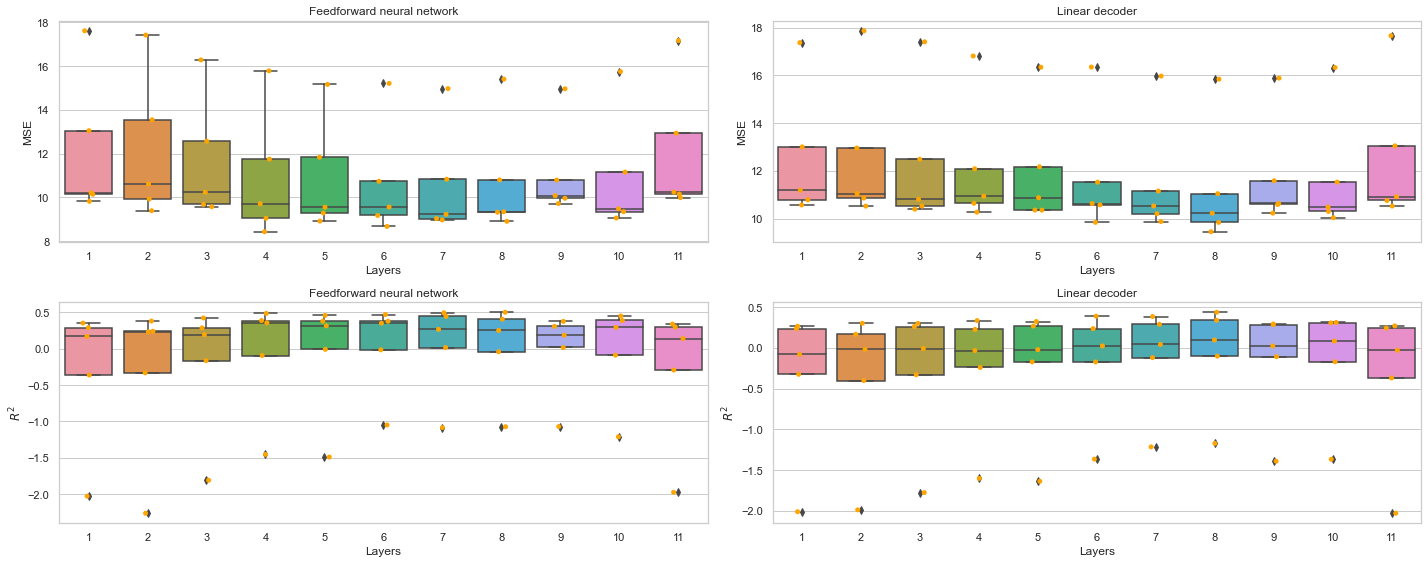

In [31]:
f = plt.figure()
plot_depth(SPEEDMSE_ffnnDEPTH,SPEEDR2_ffnnDEPTH,SPEEDMSE_linearDEPTH,SPEEDR2_linearDEPTH)
plt.savefig(folderstim+'/'+rat+'/Figures/'+rat+'_DepthSpeed.png')

### runAngle

In [32]:
# RUNANGtrained_models_ffnn, RUNANGMSE_ffnn, RUNANGR2_ffnn, RUNANGpredictions_ffnn = general_decoder(pca_zscore,pupilArea,pars,trials = 15)
# RUNANGtrained_models_linear, RUNANGMSE_linear, RUNANGR2_linear, RUNANGpredictions_linear = general_decoder(pca_zscore,pupilArea,[],trials = 15

In [33]:
# RUNANGtrained_models_ffnn, RUNANGMSE_ffnn, RUNANGR2_ffnn, RUNANGpredictions_ffnn = general_depth_decoder(xyz.T[-1],Z,runAngle,pars)
# RUNANGtrained_models_linear, RUNANGMSE_linear, RUNANGR2_linear, RUNANGpredictions_linear = general_depth_decoder(xyz.T[-1],Z,runAngle,[])